In [283]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.special import stdtr
from numpy.random import seed
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, confusion_matrix
from xgboost import XGBClassifier
from sklearn.svm import SVC

import numpy as np
from sklearn.preprocessing import LabelEncoder , StandardScaler
import plotly.express as px


In [216]:
pd.set_option('display.max_rows', None)
df = pd.read_csv(r"data_center/heart_disease_uci.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [217]:
df.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

Pas mal de données manquantes
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486

Après verification du DF sur Kaggle

id (Unique id for each patient)
age (Age of the patient in years)
origin (place of study)
sex (Male/Female)
cp chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])
trestbps resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))
chol (serum cholesterol in mg/dl)
fbs (if fasting blood sugar > 120 mg/dl)
restecg (resting electrocardiographic results)
-- Values: [normal, stt abnormality, lv hypertrophy]
thalach: maximum heart rate achieved
exang: exercise-induced angina (True/ False)
oldpeak: ST depression induced by exercise relative to rest
slope: the slope of the peak exercise ST segment
ca: number of major vessels (0-3) colored by fluoroscopy
thal: [normal; fixed defect; reversible defect]
num: the predicted attribute (0: No heart disease; 1: Mild heart disease; 2: Moderate heart disease; 3: Severe heart disease; 4: Very severe heart disease)



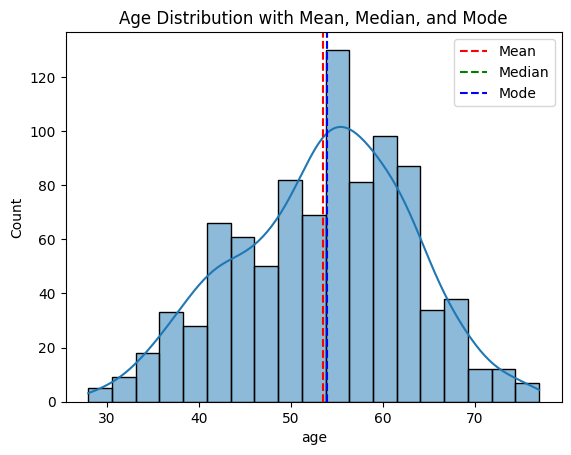

Mean of age: 53.51086956521739
Median of age: 54.0
Mode of age: 54


In [218]:
# Plot the mean , median and mode of the age column using seaborn
sns.histplot(df, x='age', kde=True)
plt.axvline(df['age'].mean(), color='r', linestyle='--', label='Mean')
plt.axvline(df['age'].median(), color='g', linestyle='--', label='Median')
plt.axvline(df['age'].mode()[0], color='b', linestyle='--', label='Mode')
plt.legend()
plt.title('Age Distribution with Mean, Median, and Mode')
plt.show()  

print("Mean of age:", df['age'].mean())
print("Median of age:", df['age'].median())
print("Mode of age:", df['age'].mode()[0])

On observe que la distribution des âges à un pic d'admission (avec ou sans symptome à 54ans), hommes/femmes mélangé

In [219]:
# Répartition des hommes et femmes
age_count = df.groupby('sex')['age'].count()
print(age_count)


sex
Female    194
Male      726
Name: age, dtype: int64


In [220]:
male_count = age_count.iloc[1]
female_count = age_count.iloc[0]

male_percentage = (male_count / age_count.sum()) * 100
female_percentage = (female_count / age_count.sum()) * 100

print(f"Male Percentage in the data: {male_percentage:.2f}%")
print(f"Female Percentage in the data: {female_percentage:.2f}%")

# difference 
difference_percentage = ((male_count - female_count) / female_count) * 100
print(f"Males are {difference_percentage:.2f}% more than females in the data")

# visualize using plotly 
fig = px.bar(age_count,color=age_count.index, title='Distribution of Male and Female in the data')
fig.show()



Male Percentage in the data: 78.91%
Female Percentage in the data: 21.09%
Males are 274.23% more than females in the data


On observe une prevalence des hommes par rapport aux femmes dans els problèmes cardiaques : 3.74 hommes pour une femme.
Les hommes représente 78.9% des cas. 
Attention toujours pas de vérification sur le predict attribute

In [221]:
df_categorical = df.select_dtypes(include=['object'])
print(df_categorical.columns)
unique_counts = df_categorical.nunique()
unique_values = {col: df_categorical[col].unique() for col in df_categorical.columns}
unique_values = {col: list(values) for col, values in unique_values.items()}

# Pour voir toutes les valeurs uniques dans les colonnes catégorielles
pd.set_option('display.max_colwidth', None)
pd.DataFrame({'Number of Unique Values': unique_counts, 'Unique Values': unique_values})

Index(['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'], dtype='object')


,Number of Unique Values,Unique Values
sex,2,"[Male, Female]"
dataset,4,"[Cleveland, Hungary, Switzerland, VA Long Beach]"
cp,4,"[typical angina, asymptomatic, non-anginal, atypical angina]"
fbs,2,"[True, False, nan]"
restecg,3,"[lv hypertrophy, normal, st-t abnormality, nan]"
exang,2,"[False, True, nan]"
slope,3,"[downsloping, flat, upsloping, nan]"
thal,3,"[fixed defect, normal, reversable defect, nan]"


In [222]:
# Répartion de l'âge par pays
fig = px.histogram(df, x='age', color='dataset',title='Distribution of age country-wise in the data')
fig.show()

J'ai l'impression que VA Long beach ont des moyenne plus haute..

In [223]:
mean_age = df.groupby('dataset')['age'].mean()
median_age = df.groupby('dataset')['age'].median()
mode_age = df.groupby('dataset')['age'].agg(pd.Series.mode)

result = pd.DataFrame({
    'Mean Age': mean_age.round(1),
    'Median Age': median_age.round(0),
    'Mode Age': mode_age
}).reset_index()

result.columns = ['Dataset', 'Mean Age', 'Median Age', 'Mode Age']
result

,Dataset,Mean Age,Median Age,Mode Age
0,Cleveland,54.4,56.0,58
1,Hungary,47.9,49.0,54
2,Switzerland,55.3,56.0,61
3,VA Long Beach,59.4,60.0,"[62, 63]"


VA Long Beach présente la moyenne d’âge la plus élevée (59,4 ans) et la médiane la plus haute (60 ans). Les modes sont également élevés (62 et 63 ans).
→ Cela indique que la population de patients de ce centre est globalement plus âgée que dans les autres datasets.

Switzerland et Cleveland ont des moyennes et des médianes proches (55,3/56 et 54,4/56), avec des modes élevés (61 et 58).
→ Les patients sont aussi relativement âgés, mais un peu moins que VA Long Beach.

Hungary a la population la plus jeune, avec une moyenne d’âge de 47,9 ans et une médiane de 49 ans. Le mode est plus bas (54 ans).
→ Les patients hongrois sont donc plus jeunes en moyenne.

On passe au cp (chest pain)

In [224]:
df['cp'].value_counts()

cp
asymptomatic       496
non-anginal        204
atypical angina    174
typical angina      46
Name: count, dtype: int64

L'asymptomatique est majoritaire

In [225]:
df.groupby('sex')['cp'].value_counts()

sex     cp             
Female  asymptomatic        70
        atypical angina     61
        non-anginal         53
        typical angina      10
Male    asymptomatic       426
        non-anginal        151
        atypical angina    113
        typical angina      36
Name: count, dtype: int64

La douleur thoracique asymptomatique est la plus courante chez les hommes (426) et les femmes (70).

L'angine typique est la moins fréquente pour les deux sexes.

In [226]:
fig = px.histogram(df, x='cp', color='sex',title='Distribution of chest pain by age in the data')
fig.show()

In [227]:
df.groupby('dataset')['cp'].value_counts()

dataset        cp             
Cleveland      asymptomatic       144
               non-anginal         86
               atypical angina     51
               typical angina      23
Hungary        asymptomatic       123
               atypical angina    105
               non-anginal         54
               typical angina      11
Switzerland    asymptomatic        98
               non-anginal         17
               atypical angina      4
               typical angina       4
VA Long Beach  asymptomatic       131
               non-anginal         47
               atypical angina     14
               typical angina       8
Name: count, dtype: int64

On observe bien que La douleur thoracique asymptomatique est la plus courante.


In [228]:
fig = px.bar(df,x='cp', color='dataset', barmode='group',title='Distribution of chest pain country-wise in the data')
fig.show()

In [229]:
df.groupby('cp')['age'].value_counts()
fig = px.histogram(df, x='age', color='cp',title='Distribution of age by chest pain in the data')
fig.show()

In [230]:
print("\nBasic Statistics for Cholesterol:")
print(df['chol'].describe())


Basic Statistics for Cholesterol:
count    890.000000
mean     199.130337
std      110.780810
min        0.000000
25%      175.000000
50%      223.000000
75%      268.000000
max      603.000000
Name: chol, dtype: float64


In [231]:
# Additional statistics
print("\nAdditional Statistics:")
print(f"Median cholesterol: {df['chol'].median()}")
print(f"Mode cholesterol: {df['chol'].mode()[0]}")


Additional Statistics:
Median cholesterol: 223.0
Mode cholesterol: 0.0


In [232]:


# Check for missing values
print("\nMissing Values Check:")
print(f"Number of missing values in cholestrol column: {df['chol'].isna().sum()}")




Missing Values Check:
Number of missing values in cholestrol column: 30


In [233]:


# Check for zeros values of cholestrol
print("\nZero/Negative Values Check:")
print(f"Number of zero values: {(df['chol'] == 0).sum()}")




Zero/Negative Values Check:
Number of zero values: 172


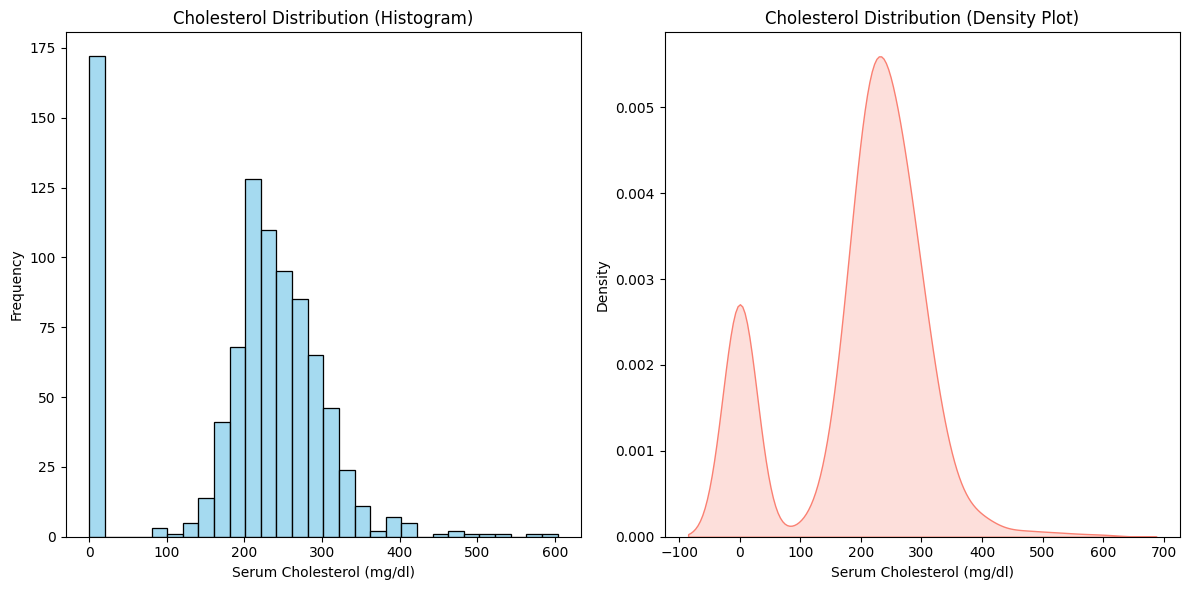

In [234]:
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['chol'], bins=30, kde=False, color='skyblue')
plt.title('Cholesterol Distribution (Histogram)')
plt.xlabel('Serum Cholesterol (mg/dl)')
plt.ylabel('Frequency')

# Density plot
plt.subplot(1, 2, 2)
sns.kdeplot(df['chol'], fill=True, color='salmon')
plt.title('Cholesterol Distribution (Density Plot)')
plt.xlabel('Serum Cholesterol (mg/dl)')

plt.tight_layout()
plt.show()

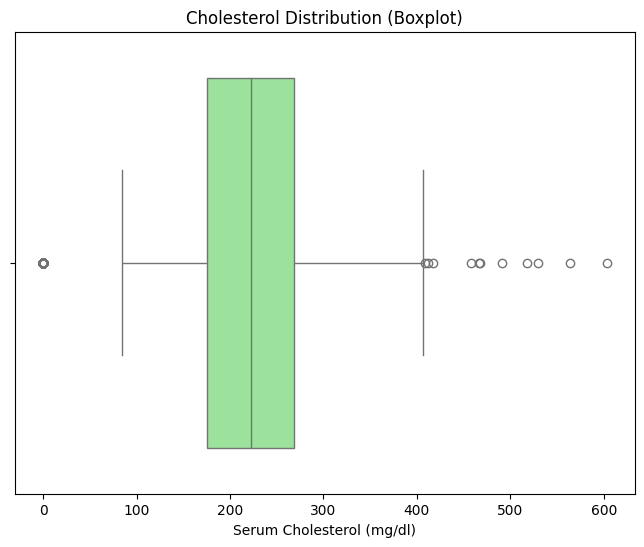

In [235]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['chol'], color='lightgreen')
plt.title('Cholesterol Distribution (Boxplot)')
plt.xlabel('Serum Cholesterol (mg/dl)')
plt.show()

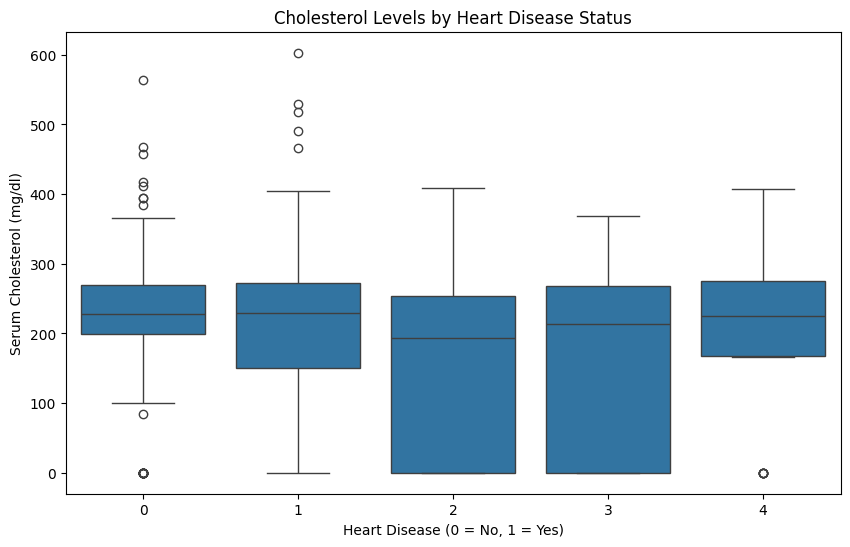

In [236]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='num', y='chol', data=df)
plt.title('Cholesterol Levels by Heart Disease Status')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Serum Cholesterol (mg/dl)')
plt.show()

Je n'ai pas l'impression que le cholesterol à une influence sur les crises cardiaques

Data Cleaning

In [237]:
df.duplicated().sum()
df.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

In [238]:
df = df.drop(columns=['ca', 'thal'])

In [239]:
df = df.dropna(subset=['restecg'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 918 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        918 non-null    int64  
 1   age       918 non-null    int64  
 2   sex       918 non-null    object 
 3   dataset   918 non-null    object 
 4   cp        918 non-null    object 
 5   trestbps  859 non-null    float64
 6   chol      888 non-null    float64
 7   fbs       829 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    863 non-null    float64
 10  exang     863 non-null    object 
 11  oldpeak   856 non-null    float64
 12  slope     610 non-null    object 
 13  num       918 non-null    int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 107.6+ KB


In [240]:
# Imputing missing values based on data distribution, data type, and relevance
# For numerical columns
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col].fillna(df[col].median(), inplace=True)
# For categorical columns
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Converting relevant columns to appropriate data types
# Example: data['column_name'] = pd.to_numeric(data['column_name'], errors='coerce')

C:\Users\alexa\AppData\Local\Temp\ipykernel_15720\420285828.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\alexa\AppData\Local\Temp\ipykernel_15720\420285828.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [241]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 918 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        918 non-null    int64  
 1   age       918 non-null    int64  
 2   sex       918 non-null    object 
 3   dataset   918 non-null    object 
 4   cp        918 non-null    object 
 5   trestbps  918 non-null    float64
 6   chol      918 non-null    float64
 7   fbs       918 non-null    bool   
 8   restecg   918 non-null    object 
 9   thalch    918 non-null    float64
 10  exang     918 non-null    bool   
 11  oldpeak   918 non-null    float64
 12  slope     918 non-null    object 
 13  num       918 non-null    int64  
dtypes: bool(2), float64(4), int64(3), object(5)
memory usage: 95.0+ KB


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0


In [242]:
df_categorical = df.select_dtypes(include=['object'])
unique_counts = df_categorical.nunique()
unique_values = {col: df_categorical[col].unique() for col in df_categorical.columns}
unique_values = {col: list(values) for col, values in unique_values.items()}

# Pour voir toutes les valeurs uniques dans les colonnes catégorielles
pd.set_option('display.max_colwidth', None)
pd.DataFrame({'Number of Unique Values': unique_counts, 'Unique Values': unique_values})

,Number of Unique Values,Unique Values
sex,2,"[Male, Female]"
dataset,4,"[Cleveland, Hungary, Switzerland, VA Long Beach]"
cp,4,"[typical angina, asymptomatic, non-anginal, atypical angina]"
restecg,3,"[lv hypertrophy, normal, st-t abnormality]"
slope,3,"[downsloping, flat, upsloping]"


In [243]:
df['sex'] = df['sex'].map({'Male': 0, 'Female': 1})
le = LabelEncoder()
df['exang'] = le.fit_transform(df['exang'])
df['fbs'] = le.fit_transform(df['fbs'])

In [244]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,num
0,1,63,0,Cleveland,typical angina,145.0,233.0,1,lv hypertrophy,150.0,0,2.3,downsloping,0
1,2,67,0,Cleveland,asymptomatic,160.0,286.0,0,lv hypertrophy,108.0,1,1.5,flat,2
2,3,67,0,Cleveland,asymptomatic,120.0,229.0,0,lv hypertrophy,129.0,1,2.6,flat,1
3,4,37,0,Cleveland,non-anginal,130.0,250.0,0,normal,187.0,0,3.5,downsloping,0
4,5,41,1,Cleveland,atypical angina,130.0,204.0,0,lv hypertrophy,172.0,0,1.4,upsloping,0


In [251]:
df_encoded = df.copy()
df_encoded = pd.get_dummies(df_encoded, columns=['dataset'], drop_first=False)
df_encoded.info()


<class 'pandas.core.frame.DataFrame'>
Index: 918 entries, 0 to 919
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     918 non-null    int64  
 1   age                    918 non-null    int64  
 2   sex                    918 non-null    int64  
 3   cp                     918 non-null    object 
 4   trestbps               918 non-null    float64
 5   chol                   918 non-null    float64
 6   fbs                    918 non-null    int64  
 7   restecg                918 non-null    object 
 8   thalch                 918 non-null    float64
 9   exang                  918 non-null    int64  
 10  oldpeak                918 non-null    float64
 11  slope                  918 non-null    object 
 12  num                    918 non-null    int64  
 13  dataset_Cleveland      918 non-null    bool   
 14  dataset_Hungary        918 non-null    bool   
 15  dataset_Swi

In [254]:
for col in ['cp', 'restecg', 'slope']:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

Mean Absolute Error: 0.5652173913043478
Accuracy: 0.6195652173913043
              precision    recall  f1-score   support

           0       0.70      0.90      0.79        71
           1       0.68      0.58      0.62        59
           2       0.47      0.26      0.33        27
           3       0.31      0.38      0.34        21
           4       0.50      0.17      0.25         6

    accuracy                           0.62       184
   macro avg       0.53      0.46      0.47       184
weighted avg       0.61      0.62      0.60       184

[[64  3  1  3  0]
 [18 34  4  3  0]
 [ 4  6  7 10  0]
 [ 4  6  2  8  1]
 [ 1  1  1  2  1]]


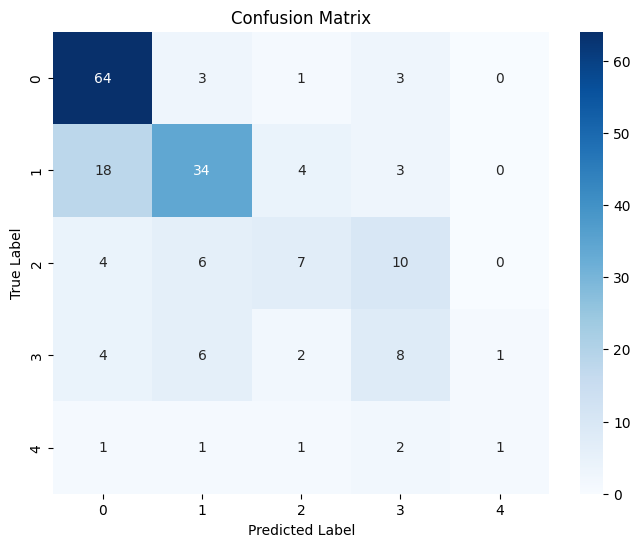

F1 macro: 0.468
Precision macro: 0.532
Recall macro: 0.457


In [278]:
# Multiclass Classification Machine learnig
X = df_encoded.drop(columns=['num'])
y = df_encoded['num']
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, )
# Using Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
# Making predictions
y_pred = rf_model.predict(X_test)
# Evaluating the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Accuracy:", rf_model.score(X_test, y_test))

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Calcul de la matrice de confusion (assure-toi que y_pred est bien un array d'entiers)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1', '2', '3', '4'],
            yticklabels=['0', '1', '2', '3', '4'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import f1_score, precision_score, recall_score

f1_macro = f1_score(y_test, y_pred, average='macro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"F1 macro: {f1_macro:.3f}")
print(f"Precision macro: {precision_macro:.3f}")
print(f"Recall macro: {recall_macro:.3f}")

Accuracy ~62% : Le modèle prédit correctement 
Précision et rappel élevés pour la classe 0 (pas de maladie) :
La classe 0 est bien identifiée (précision 0.70, rappel 0.90), ce qui signifie que le modèle est plutôt fiable pour détecter les cas négatifs.

Performances plus faibles pour les autres classes (1 à 4) :
Les classes représentant différents stades ou types de maladie sont plus difficiles à prédire, avec des f1-scores autour de 0.3 à 0.6.

    La classe 1 a un rappel plus faible (0.58) indiquant que certains cas positifs sont manqués.

    Les classes 2, 3, 4 sont peu représentées (notamment la classe 4 avec seulement 6 exemples) et ont des scores faibles, ce qui est normal en apprentissage supervisé avec peu de données.

F1 macro (~0.47) montre un équilibre modéré entre précision et rappel global, mais reste perfectible.

Matrice de confusion : les erreurs sont surtout des confusions entre classes proches, ce qui peut indiquer que les données manquent de caractéristiques discriminantes fortes.

c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning:

[20:41:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Mean Absolute Error: 0.625
Accuracy: 0.5978260869565217


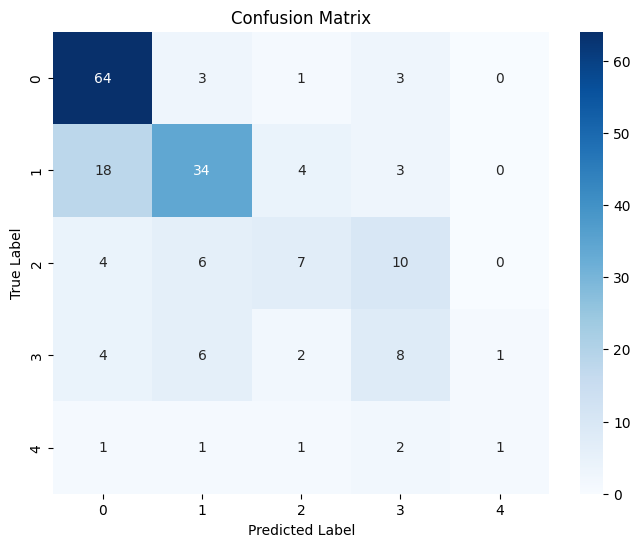

F1 macro: 0.416
Precision macro: 0.418
Recall macro: 0.422


In [282]:
#XGBoost
X = df_encoded.drop(columns=['num'])
y = df_encoded['num']
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Using XGBoost Regress
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
# Making predictions    
y_pred = xgb_model.predict(X_test)
# Evaluating the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Accuracy:", xgb_model.score(X_test, y_test))


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1', '2', '3', '4'],
            yticklabels=['0', '1', '2', '3', '4'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import f1_score, precision_score, recall_score

f1_macro = f1_score(y_test, y_pred, average='macro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"F1 macro: {f1_macro:.3f}")
print(f"Precision macro: {precision_macro:.3f}")
print(f"Recall macro: {recall_macro:.3f}")

            

Mean Absolute Error: 0.6467391304347826
Accuracy: 0.5380434782608695


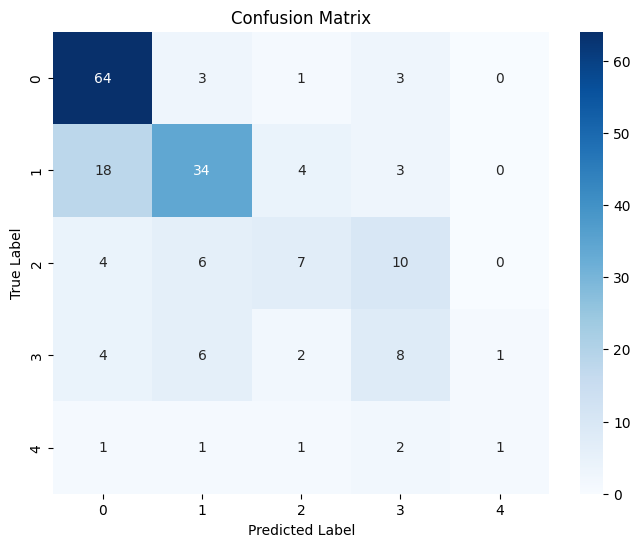

F1 macro: 0.302
Precision macro: 0.279
Recall macro: 0.331


c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [284]:
#SVC
X = df_encoded.drop(columns=['num'])
y = df_encoded['num']
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Using SVC
svc_model = SVC(kernel='linear', random_state=42)
svc_model.fit(X_train, y_train)
# Making predictions
y_pred = svc_model.predict(X_test)
# Evaluating the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Accuracy:", svc_model.score(X_test, y_test)) 

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1', '2', '3', '4'],
            yticklabels=['0', '1', '2', '3', '4'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import f1_score, precision_score, recall_score

f1_macro = f1_score(y_test, y_pred, average='macro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"F1 macro: {f1_macro:.3f}")
print(f"Precision macro: {precision_macro:.3f}")
print(f"Recall macro: {recall_macro:.3f}")


Les 2 autres models sont moins bon que le random Forest